Test whether neg voja with recurrence can actually learn an association

In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (BasicVecFeed, meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [3]:
with h5py.File(os.path.join(data_path, "neg_voja_weights", "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
with h5py.File(os.path.join(data_path, "neg_voja_weights", "less_base_inhib_match_weights_alt2.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [5]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [6]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [155]:
t_pause = 0.2
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)
td_present = int(t_present/dt)

In [8]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [9]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Train

In [234]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

### Analytically

In [235]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as base_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

    p_in = nengo.Probe(in_nd, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(ens.neurons, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [270]:
def remove_pauses(resp: np.ndarray, dims: int) -> np.ndarray:
    pre_slc_shape = (td_each, dims, len(feed_vecs))
    reshaped_resp = resp[td_pause:].reshape(pre_slc_shape, order='F')
    return reshaped_resp[:td_present].reshape((-1, dims), order='F')

In [276]:
base_sim.data[p_cor][td_pause:].reshape(td_each, -1, 32).shape

(500, 32, 32)

In [277]:
activities = remove_pauses(base_sim.data[p_spikes], n_neurons)
targets = remove_pauses(base_sim.data[p_cor], 32)

In [252]:
pre_slc_shape = (td_each, n_neurons, len(feed_vecs)
reshaped_acts = full_acts[td_pause:].reshape(pre_slc_shape), order='F')
reshaped_cor = 
reshaped_acts.shape

(500, 500, 32)

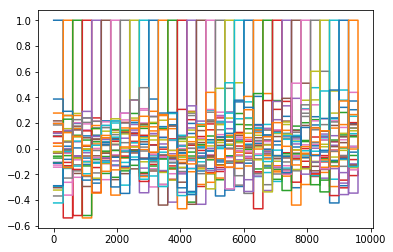

In [280]:
plt.plot(spa.similarity(targets, all_fan_vecs));

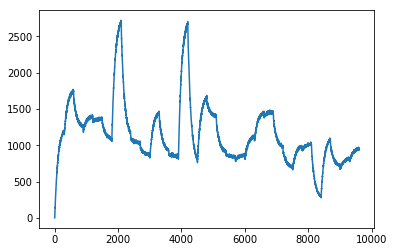

In [278]:
plt.plot(meg_from_spikes(activities))

In [281]:
solver = nengo.solvers.LstsqL2(reg=0.02)

In [314]:
dec, rmse = solver(activities, targets)
dec = dec.T

# Test

In [316]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)
    nd_comp = nengo.Node(lambda t, x: np.dot(x[:dimensions], x[dimensions:]),
                         size_in=2*dimensions, size_out=1)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)
    nengo.Connection(ens.neurons, output, transform=dec)
    
    nengo.Connection(output, nd_comp[:dimensions], synapse=None)
    nengo.Connection(correct, nd_comp[dimensions:])
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)
    p_comp = nengo.Probe(nd_comp, synapse=0.005)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

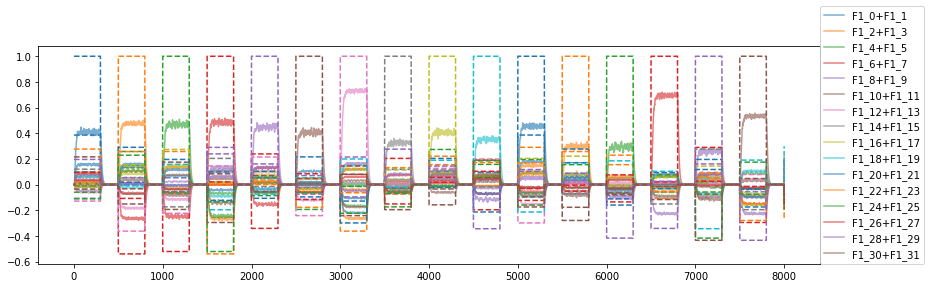

In [317]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs), linestyle="--")
plt.legend(fan1, loc=(1, 0))

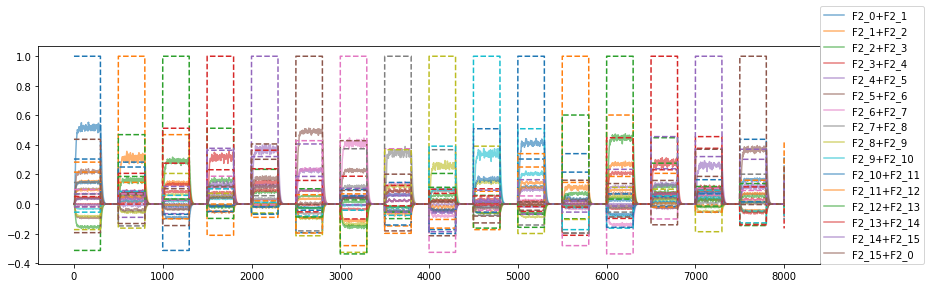

In [318]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs), linestyle="--")
plt.legend(fan2, loc=(1, 0))

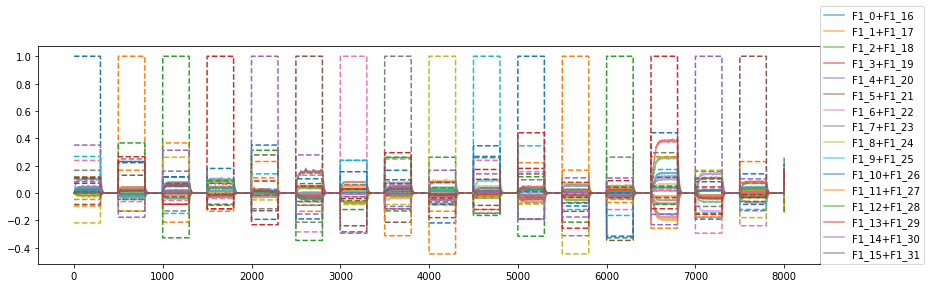

In [319]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs), linestyle="--")
plt.legend(foil1, loc=(1, 0))

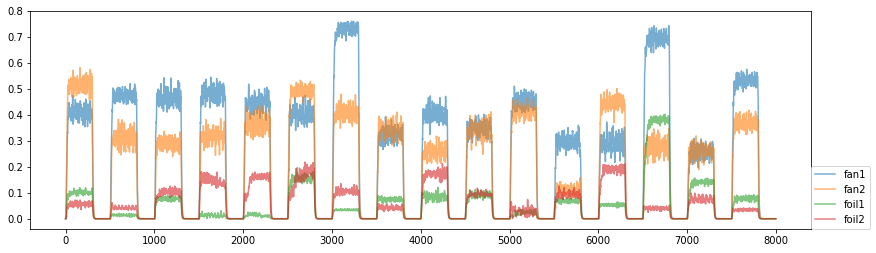

In [320]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_comp][fan1_slc], alpha=0.6, label="fan1")
plt.plot(test_sim.data[p_comp][fan2_slc], alpha=0.6, label="fan2")
plt.plot(test_sim.data[p_comp][foil1_slc], alpha=0.6, label="foil1")
plt.plot(test_sim.data[p_comp][foil2_slc], alpha=0.6, label="foil2")
plt.legend(loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [321]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [322]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [323]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[121.46057476 140.41083261 138.32485777 143.24842791 133.05558969
 120.08296059 213.12504484  96.22667376 118.93290712 103.5176344
 135.12815573  87.76478669  86.73479    203.68017998  75.70083304
 156.79604983]
129.63689366911024


In [324]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [325]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[153.13727522  91.46491011  86.27844991  93.12320046 109.88165247
 144.75792069 121.61695488 102.66745826  76.39159917 100.40739584
 122.59048201  33.31475389 131.72775227  83.25728574  77.93080266
 109.29954167]
102.36546470447294


## Compare reaction times

In [326]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [327]:
def n_ans_conf(comp_res: np.ndarray, num_items: int, td_item: int, td_pres: int) -> np.ndarray:
    ind_ans = comp_res.reshape((td_item, num_items, -1), order='F').squeeze()
    return np.sum(ind_ans[:td_pres], axis=0)

In [328]:
neural_confs = {}
for nm, obj in slc_stim_vecs.items():
    conf_res = n_ans_conf(test_sim.data[p_comp][obj.slc], len(obj.vecs), td_each, td_present)
    neural_confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 125.2568335860984
fan2 98.80638809390763
foil1 24.90871706462483
foil2 27.575141302840024


In [329]:
nconf_df = pd.DataFrame(neural_confs)

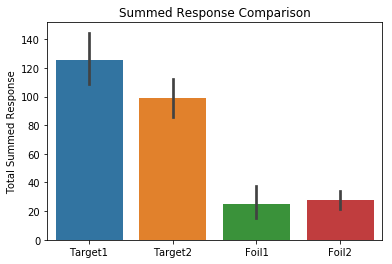

In [335]:
ax = sns.barplot(data=nconf_df)
ax.set_xticklabels(("Target1", "Target2", "Foil1", "Foil2"))
ax.set_ylabel("Total Summed Response")
ax.set_title("Summed Response Comparison");